In [1]:
%matplotlib inline
# 序列模型
import torch
from torch import nn
from d2l import torch as d2l

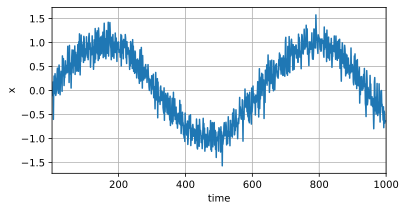

In [2]:
T= 1000

time = torch.arange(1, T+1,dtype=torch.float32)
x = torch.sin(0.01*time) + torch.normal(0,0.2,(T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1,1000], figsize=(6,3))

In [5]:
tau = 4
features = torch.zeros((T-tau, tau))
for i in range(tau):
    features[:, i]=x[i:T-tau+i]
labels = x[tau:].reshape((-1, 1))

In [6]:
batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train],labels[:n_train]),batch_size, is_train=True)

In [11]:
#初始化网络权重
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
#一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4,10),
                        nn.ReLU(),
                        nn.Linear(10,1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss(reduction='none')

In [13]:
def train(net, train_iter, loss, num_epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(num_epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l=loss(net(X),y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch+1},'
              f'loss: {d2l.evaluate_loss(net,train_iter,loss):f}')
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1,loss: 0.075594
epoch 2,loss: 0.066404
epoch 3,loss: 0.060849
epoch 4,loss: 0.058400
epoch 5,loss: 0.054617


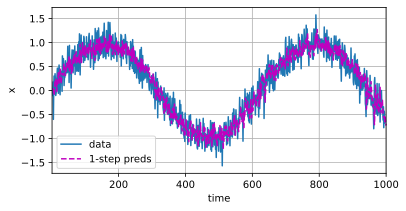

In [14]:
onestep_preds =net(features)

d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()],'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

In [17]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train+tau] = x[:n_train+tau]
for i in range(n_train+tau, T):
    multistep_preds[i] = net(
        multistep_preds[i-tau:i].reshape((1, -1))
    )

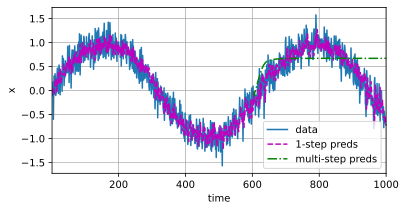

In [18]:
d2l.plot([time, time[tau:], time[n_train+tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train+tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds','multi-step preds'],
         xlim=[1,1000],figsize=(6,3))

In [19]:
max_steps=64
features = torch.zeros((T-tau-max_steps+1, tau+max_steps))

for i in range(tau):
    features[:, i] = x[i: i+T - tau -max_steps+1]

for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:,i-tau:i]).reshape(-1)

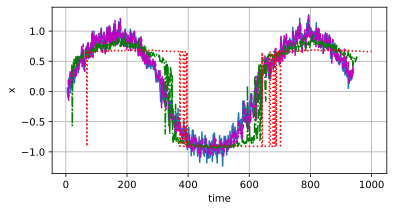

In [20]:
steps=(1, 4, 16, 64)

d2l.plot([time[tau+i-1:T-max_steps+i] for i in steps],
         [features[:, (tau+i-1)].detach().numpy() for i in steps],'time','x',
         figsize=(6, 3))